In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import statsmodels.api as sm

In [2]:
train = pd.read_csv('data/train.csv', dtype={'WindSpeed': 'object'})

In [3]:
def split_play_and_player_cols(df, predicting=False):
    df['IsRusher'] = df['NflId'] == df['NflIdRusher']
    
    df['PlayId'] = df['PlayId'].astype(str)
    
    player_cols = [
        'PlayId', # This is the link between them
        'Season',
        'Team',
        'X',
        'Y',
        'S',
        'Dis',
        'Dir',
        'NflId',
        'IsRusher',
    ]

    df_players = df[player_cols]
    
    play_cols = [
        'PlayId',
        'Season',
        'PossessionTeam',
        'HomeTeamAbbr',
        'VisitorTeamAbbr',
        'PlayDirection', 
        'FieldPosition',
        'YardLine',
    ]
    
    if not predicting:
        play_cols.append('Yards')
        
    df_play = df[play_cols].copy()
    
    # Get first 
    df_play = df_play.groupby('PlayId').first().reset_index()

    print('rows/plays in df: ', len(df_play))
    assert df_play.PlayId.nunique() == df.PlayId.nunique(), "Play/player split failed?"  # Boom
    
    return df_play, df_players

play_ids = train["PlayId"].unique()

df_play, df_players = split_play_and_player_cols(train)

rows/plays in df:  31007


In [4]:
def process_team_abbr(df):

    #These are only problems:
    map_abbr = {'ARI': 'ARZ', 'BAL': 'BLT', 'CLE': 'CLV', 'HOU': 'HST'}
    for abb in train['PossessionTeam'].unique():
        map_abbr[abb] = abb

    df['PossessionTeam'] = df['PossessionTeam'].map(map_abbr)
    df['HomeTeamAbbr'] = df['HomeTeamAbbr'].map(map_abbr)
    df['VisitorTeamAbbr'] = df['VisitorTeamAbbr'].map(map_abbr)

    df['HomePossession'] = df['PossessionTeam'] == df['HomeTeamAbbr']
    
    return

process_team_abbr(df_play)

In [5]:

def process_play_direction(df):
    df['IsPlayLeftToRight'] = df['PlayDirection'].apply(lambda val: True if val.strip() == 'right' else False)
    return

process_play_direction(df_play)

In [6]:
def process_yard_til_end_zone(df):
    def convert_to_yardline100(row):
        return (100 - row['YardLine']) if (row['PossessionTeam'] == row['FieldPosition']) else row['YardLine']
    df['Yardline100'] = df.apply(convert_to_yardline100, axis=1)
    return

process_yard_til_end_zone(df_play)

In [7]:

df_players = df_players.merge(
    df_play[['PlayId', 'PossessionTeam', 'HomeTeamAbbr', 'PlayDirection', 'Yardline100']], 
    how='left', on='PlayId')

<AxesSubplot:title={'center':'Season 2017'}, xlabel='Dis', ylabel='S'>

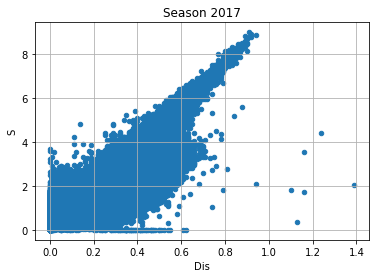

In [8]:
df_players.loc[df_players.Season == 2017].plot.scatter(x='Dis', y='S', title='Season 2017',grid=True)

<AxesSubplot:title={'center':'Season 2018'}, xlabel='Dis', ylabel='S'>

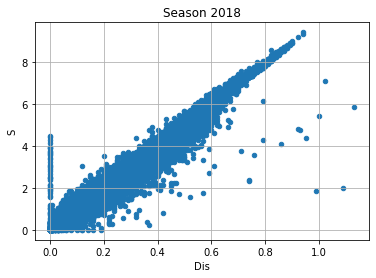

In [9]:
df_players.loc[df_players.Season == 2018].plot.scatter(x='Dis', y='S', title='Season 2018', grid=True)


In [10]:
X = df_players.loc[df_players.Season == 2018]['Dis']
y = df_players.loc[df_players.Season == 2018]['S']
X = sm.add_constant(X)

model = sm.OLS(y, X).fit() 
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      S   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                 1.137e+07
Date:                Sat, 23 Jul 2022   Prob (F-statistic):               0.00
Time:                        21:23:11   Log-Likelihood:                 32141.
No. Observations:              247962   AIC:                        -6.428e+04
Df Residuals:                  247960   BIC:                        -6.426e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.001      1.182      0.237      -0.001       0.003
Dis            9.9228      0.003   3372.410      0.000       9.917       9.929
==============================================================================
Omnibus:                   145982.942   Durbin-Watson:                   1.918
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         19682710.631
Skew:                          -1.861   Prob(JB):                         0.00
Kurtosis:                      46.488   Cond. No.                         7.44
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [11]:
df_players.loc[df_players.Season == 2017, 'S'] = 10*df_players.loc[df_players.Season == 2017,'Dis']


In [12]:
def standarize_direction(df):
    # adjusted the data to always be from left to right
    df['HomePossesion'] = df['PossessionTeam'] == df['HomeTeamAbbr']

    df['Dir_rad'] = np.mod(90 - df.Dir, 360) * math.pi/180.0

    df['ToLeft'] = df.PlayDirection == "left"
    df['TeamOnOffense'] = "home"
    df.loc[df.PossessionTeam != df.HomeTeamAbbr, 'TeamOnOffense'] = "away"
    df['IsOnOffense'] = df.Team == df.TeamOnOffense # Is player on offense?
    df['X_std'] = df.X
    df.loc[df.ToLeft, 'X_std'] = 120 - df.loc[df.ToLeft, 'X']
    df['Y_std'] = df.Y
    df.loc[df.ToLeft, 'Y_std'] = 160/3 - df.loc[df.ToLeft, 'Y']
    df['Dir_std'] = df.Dir_rad
    df.loc[df.ToLeft, 'Dir_std'] = np.mod(np.pi + df.loc[df.ToLeft, 'Dir_rad'], 2*np.pi)
   
    #Replace Null in Dir_rad
    df.loc[(df.IsOnOffense) & df['Dir_std'].isna(),'Dir_std'] = 0.0
    df.loc[~(df.IsOnOffense) & df['Dir_std'].isna(),'Dir_std'] = np.pi

standarize_direction(df_players)

### Data augmentation

In [13]:
def data_augmentation(df, sample_ids):
    df_sample = df.loc[df.PlayId.isin(sample_ids)].copy()
    df_sample['Y_std'] = 160/3  - df_sample['Y_std']
    df_sample['Dir_std'] = df_sample['Dir_std'].apply(lambda x: 2*np.pi - x)
    df_sample['PlayId'] = df_sample['PlayId'].apply(lambda x: x+'_aug')
    return df_sample

def process_tracking_data(df):
    # More feature engineering for all:
    df['Sx'] = df['S']*df['Dir_std'].apply(math.cos)
    df['Sy'] = df['S']*df['Dir_std'].apply(math.sin)
    
    # ball carrier position
    rushers = df[df['IsRusher']].copy()
    rushers.set_index('PlayId', inplace=True, drop=True)
    playId_rusher_map = rushers[['X_std', 'Y_std', 'Sx', 'Sy']].to_dict(orient='index')
    rusher_x = df['PlayId'].apply(lambda val: playId_rusher_map[val]['X_std'])
    rusher_y = df['PlayId'].apply(lambda val: playId_rusher_map[val]['Y_std'])
    rusher_Sx = df['PlayId'].apply(lambda val: playId_rusher_map[val]['Sx'])
    rusher_Sy = df['PlayId'].apply(lambda val: playId_rusher_map[val]['Sy'])
    
    # Calculate differences between the rusher and the players:
    df['player_minus_rusher_x'] = rusher_x - df['X_std']
    df['player_minus_rusher_y'] = rusher_y - df['Y_std']

    # Velocity parallel to direction of rusher:
    df['player_minus_rusher_Sx'] = rusher_Sx - df['Sx']
    df['player_minus_rusher_Sy'] = rusher_Sy - df['Sy']

    return

sample_ids = np.random.choice(df_play.PlayId.unique(), int(0.5*len(df_play.PlayId.unique())))

df_players_aug = data_augmentation(df_players, sample_ids)
df_players = pd.concat([df_players, df_players_aug])
df_players.reset_index()

df_play_aug = df_play.loc[df_play.PlayId.isin(sample_ids)].copy()
df_play_aug['PlayId'] = df_play_aug['PlayId'].apply(lambda x: x+'_aug')
df_play = pd.concat([df_play, df_play_aug])
df_play.reset_index()

# This is necessary to maintain the order when in the next cell we use groupby
df_players.sort_values(by=['PlayId'],inplace=True)
df_play.sort_values(by=['PlayId'],inplace=True)

process_tracking_data(df_players)

In [14]:
tracking_level_features = [
    'PlayId',
    'IsOnOffense',
    'X_std',
    'Y_std',
    'Sx',
    'Sy',
    'player_minus_rusher_x',
    'player_minus_rusher_y',
    'player_minus_rusher_Sx',
    'player_minus_rusher_Sy',
    'IsRusher'
]

df_all_feats = df_players[tracking_level_features]

print('Any null values: ', df_all_feats.isnull().sum().sum())

Any null values:  0


### Graphs Building ###

In [15]:
# Transform Y into indexed-classes:
train_y = df_play[['PlayId', 'Yards']].copy()

train_y['YardIndex'] = train_y['Yards'].apply(lambda val: val + 99)

min_idx_y = 71
max_idx_y = 150

train_y['YardIndexClipped'] = train_y['YardIndex'].apply(
    lambda val: min_idx_y if val < min_idx_y else max_idx_y if val > max_idx_y else val)

print('max yardIndex: ', train_y.YardIndex.max())
print('max yardIndexClipped: ', train_y.YardIndexClipped.max())
print('min yardIndex: ', train_y.YardIndex.min())
print('min yardIndexClipped: ', train_y.YardIndexClipped.min())

max yardIndex:  198
max yardIndexClipped:  150
min yardIndex:  84
min yardIndexClipped:  84


In [16]:
import torch
from torch_geometric.data import Data

graph_dataset = []
grouped = df_all_feats.groupby('PlayId', as_index=False)
for name, group in grouped:
    group.reset_index(drop=True, inplace=True)
    nodes_features = []
    edges_features = []
    senders = []
    receivers = []
    for i, row in group.iterrows():
        node = [row["Sx"]]
        node.append(row["Sy"])
        node.append(row["player_minus_rusher_x"])
        node.append(row["player_minus_rusher_y"])
        node.append(row["player_minus_rusher_Sx"])
        node.append(row["player_minus_rusher_Sy"])
        is_on_defense = not row["IsOnOffense"]
        node.append(is_on_defense)
        nodes_features.append(node)

        if is_on_defense:
            for j, row2 in group.iterrows():
                if row2["IsOnOffense"] and not row["IsRusher"]:
                    edge = [row2["X_std"] - row["X_std"]]
                    edge.append(row2["Y_std"] - row["Y_std"])
                    edge.append(row2["Sx"] - row["Sx"])
                    edge.append(row2["Sy"] - row["Sy"])
                    edges_features.append(edge)
                    senders.append(j)
                    receivers.append(i)

    edge_index = torch.tensor([senders, receivers], dtype=torch.long)
    x = torch.tensor(nodes_features, dtype=torch.float)
    edge_attr = torch.tensor(edges_features, dtype=torch.float)
    graph_pass = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
    graph_dataset.append([graph_pass, train_y.loc[train_y["PlayId"] == name, "YardIndexClipped"].values[0].item()])

### Traininig

In [17]:
import torch
from torch_geometric.data import Data

from torch_geometric.loader import DataLoader
from torch_geometric.nn import MessagePassing, global_mean_pool
from torch.nn import Sequential as Seq, Linear, ReLU
import torch.nn.functional as F

train_size = int(0.8 * len(graph_dataset))
test_size = len(graph_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(graph_dataset, [train_size, test_size])


In [18]:
learning_rate = 1e-3
batch_size = 64
epochs = 30

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

n_edges_features = 4
n_nodes_features = 6
min_idx_y = 71
max_idx_y = 150
num_classes = max_idx_y - min_idx_y + 1

# Model
class EdgeBlockNodeBlock(MessagePassing):
    def __init__(self, n_nodes_features, n_edges_features):
        super().__init__(aggr='mean')
        self.mlp_edges = Seq(
            Linear(n_edges_features + n_nodes_features, 128),
            ReLU(),
            Linear(128, 160),
            ReLU(),
            Linear(160, 128),
            ReLU())

        self.mlp_nodes = Seq(
            Linear(128, 160),
            ReLU(),
            Linear(160, 96),
            ReLU(),
            Linear(96, 96),
            ReLU())

    def forward(self, x, edge_index, edge_attr):
        return self.propagate(edge_index, x=x, edge_attr=edge_attr)

    def message(self, x_i, edge_attr):
        #print(x_i.shape, x_j.shape, edge_attr.shape)
        tmp = torch.cat([x_i, edge_attr], dim=-1)
        return self.mlp_edges(tmp)

    def update(self, aggr_out, x):
        #print(aggr_out.shape, x.shape)
        return self.mlp_nodes(aggr_out)


class GCN(torch.nn.Module):
    def __init__(self, n_nodes_features, n_edges_features):
        super(GCN, self).__init__()
        torch.manual_seed(45)
        self.edge_node_block =  EdgeBlockNodeBlock(n_nodes_features, n_edges_features)
        self.linear_1 = Linear(96, 96)
        self.linear_2 = Linear(96, 256)
        self.linear_3 = Linear(256, num_classes)

    def forward(self, node_attr, edge_index, edge_attr, batch):
        # 1. Obtain node embeddings
        x = self.edge_node_block(node_attr[:, :-1], edge_index, edge_attr)

        # 2. Readout layer
        mask = node_attr[:,-1].view(-1, 1)
        x =  x*mask
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.relu(self.linear_1(x))
        x = F.relu(self.linear_2(x))
        x = F.dropout(x, p=0.3, training=self.training)
        x = F.softmax(self.linear_3(x))
        return x

model = GCN(n_nodes_features, n_edges_features)

# Initialize the loss function
def crps(y_true, y_pred):
    loss = torch.mean(torch.sum((torch.cumsum(y_pred, axis = 1) - torch.cumsum(y_true, axis=1))**2, axis=1))/199
    return loss

loss_fn = crps

# Optimzer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [19]:

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss = 0
    model.train()
    for batch, (data_graph, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(data_graph.x, data_graph.edge_index, data_graph.edge_attr, data_graph.batch)
        y_train_values = torch.zeros((len(y), num_classes), dtype=torch.float32)
        for irow, row in enumerate(y):
            y_train_values[(irow, row - min_idx_y)] = 1

        loss = loss_fn(pred, y_train_values)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * data_graph.num_graphs
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    train_loss /= num_batches
    print(f"Avg train loss: {train_loss:>8f}\n")

def test_loop(dataloader, model, loss_fn):
    num_batches = len(dataloader)
    test_loss = 0
    model.eval()
    with torch.no_grad():
        for (data_graph, y) in dataloader:
            pred = model(data_graph.x, data_graph.edge_index, data_graph.edge_attr, data_graph.batch)
            y_val_values = torch.zeros((len(y), num_classes), dtype=torch.float32)
            for irow, row in enumerate(y):
                y_val_values[(irow, row - min_idx_y)] = 1
            test_loss += loss_fn(pred, y_val_values).item()

    test_loss /= num_batches
    print(f"Avg loss: {test_loss:>8f} \n")
    return test_loss

In [20]:
best_loss = np.inf
best_model = None
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loss = test_loop(test_dataloader, model, loss_fn)
    if test_loss < best_loss:
        best_loss = test_loss
        best_model = model
        print("Saving model...")
        torch.save(best_model.state_dict(), "./training_data/model_torch.pt")

print("Done!")

Epoch 1
-------------------------------
loss: 0.038334  [    0/34531]


/var/folders/8d/2gpjxrf10gx49fkn_8lqnmtm0000gn/T/ipykernel_14935/3383554097.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.linear_3(x))


loss: 0.016187  [ 6400/34531]
loss: 0.012294  [12800/34531]
loss: 0.014353  [19200/34531]
loss: 0.014334  [25600/34531]
loss: 0.014752  [32000/34531]
Avg train loss: 0.014483

Avg loss: 0.014033 

Saving model...
Epoch 2
-------------------------------
loss: 0.017725  [    0/34531]
loss: 0.015564  [ 6400/34531]
loss: 0.012664  [12800/34531]
loss: 0.015811  [19200/34531]
loss: 0.013549  [25600/34531]
loss: 0.014343  [32000/34531]
Avg train loss: 0.013608

Avg loss: 0.013786 

Saving model...
Epoch 3
-------------------------------
loss: 0.012419  [    0/34531]
loss: 0.010884  [ 6400/34531]
loss: 0.014499  [12800/34531]
loss: 0.012943  [19200/34531]
loss: 0.016688  [25600/34531]
loss: 0.017668  [32000/34531]
Avg train loss: 0.013226

Avg loss: 0.013215 

Saving model...
Epoch 4
-------------------------------
loss: 0.010907  [    0/34531]
loss: 0.014378  [ 6400/34531]
loss: 0.015366  [12800/34531]
loss: 0.012451  [19200/34531]
loss: 0.011220  [25600/34531]
loss: 0.011749  [32000/34531]
A